<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Supervised Machine Learning: Classification - Final Assignment</font></h1>

## Importing required libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
import lime.lime_tabular
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Importing the dataset

In [4]:
filepath = "data/pgafulldata.csv"
data = pd.read_csv(filepath, encoding='latin1')
data.head()

,PLAYER NAME,Ball Speed,Driving Distance,Approaches from > 100 yards,Eagles (Holes per),Putts Per Round,Birdie Average,Proximity to Hole,FedexCup Regular Season Points,Average Distance of Putts made,...,Total Birdies,Total Eagles,Spin Rate,Top 10 Finishes,Sand Save Percentage,Scrambling,SG: Total,Smash Factor,Country,College
0,A.J. McInerney (2018),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,USA,"University of Nevada-Las Vegas 2016, Finance"
1,Aaron Wise (2017),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,USA,University of Oregon
2,Aaron Wise (2018),171.85,302.9,"33' 5""",264.0,29.15,4.11,"36' 8""",1086.0,"79' 2""",...,362.0,6.0,2580.3,4.0,47.92,56.28,0.703,1.502,USA,University of Oregon
3,Aaron Wise (2019),174.29,302.6,"33' 10""",414.0,29.25,4.42,"37' 5""",400.0,"72' 1""",...,305.0,3.0,2331.3,1.0,48.19,52.05,0.329,1.495,USA,University of Oregon
4,Abraham Ancer (2016),159.60,276.4,"32' 4""",864.0,29.06,3.33,"34' 9""",147.0,"65' 4""",...,160.0,1.0,2604.7,NaN,46.75,56.67,-0.727,1.493,MEX,"University of Oklahoma 2013, Multi-Disciplinar..."


# 1. About the Data

## Dataset Summary
This dataset contains the statistics for the top 200 PGA Tour players from 2015-2019. The original dataset comprises of 29 columns with stats about every aspect of their game, including driving distance, putts per round, proximity to the hole, and many more.
<br><br>
The primary purpose of this analysis is to determine what factors led to these players either having or not having a top ten finish in the year that the statistics were collected.

## Objective of the Analysis
In this analysis of PGA Tour data, the model to be constructed will mostly focus on interpretation. While the model will try and predict whether or not a player will have a top ten finish, there is more interest on the features that drive those predictions. This will tell us the aspects of the golf game that most directly lead high finishes.

## Data Cleaning and Feature Engineering
Below are listed all of the actions taken to clean the data and implement new features:
- Any distance related metric that was measured in feet and inches was converted to a decimal in feet
- This dataset included a lot superfluous statistics that do not relate to performance, so any of those are removed
- If a player did not record a top ten finish, the column was labeled NAN, so that was changed to 0
- A new column (our target column) was created to indicate if a player had a top ten finish or not (0 if they didn't, 1 if they did)
- Many rows had almost all null values, so any rows with a null value were discarded.

In [5]:
#Replace any NAN values with 0 for top ten finishes column
def no_top_ten_replacer(value):
    if pd.isna(value):
        return 0
    else:
        return value
    
#Determines if a player has a top ten finish or not
def top_ten_bool(value):
    if value:
        return 1
    else:
        return 0

#Seperating the name column into a name and year column
def obj_to_int(obj):
    if pd.isna(obj):
        return None
    
    return int(obj)

data['Player Name'] = data['PLAYER NAME'].str.extract(r'^(.*) \(\d{4}\)$')
data['Year'] = data['PLAYER NAME'].str.extract(r'\((\d{4})\)')
data['Year'] = data['Year'].apply(obj_to_int)

#Function to convert distance to a decimal
def feet_inches_string_to_decimal(ft_inches_str):
    if pd.isna(ft_inches_str) or ft_inches_str.strip == "":
        return None
    
    clean_str = ft_inches_str.replace("'", "")
    clean_str = clean_str.replace("\"", "")
    parts = clean_str.split(" ")
    if len(parts) != 2:
        return None
    
    height = 0
    height += int(parts[0]) + float(int(parts[1])/12)
    return height

#Convert all feet and inches columns to decimals using the function above
data['Decimal Approach from > 100 Yards (Feet)'] = data['Approaches from > 100 yards'].apply(feet_inches_string_to_decimal)
data['Average Distance Putts Made (Feet)'] = data['Average Distance of Putts made'].apply(feet_inches_string_to_decimal)
data['Decimal Proximity to Hole (Feet)'] = data['Proximity to Hole'].apply(feet_inches_string_to_decimal)
data['Top 10 Finishes'] = data['Top 10 Finishes'].apply(no_top_ten_replacer)

#Create the target column, top ten finish (T10?)
data['T10?'] = data['Top 10 Finishes'].apply(top_ten_bool)

#Removing all unecessary columns
data.drop(columns=['Eagles (Holes per)', 'FedexCup Regular Season Points', 'Official Money',
                   'Total Birdies', 'Total Eagles', 'Country', 'College', 'Top 10 Finishes',
                   'PLAYER NAME', 'Approaches from > 100 yards', 'Average Distance of Putts made',
                   'Proximity to Hole', 'Player Name', 'Year'], inplace=True)

#Finally, removing any rows with null values, as there are many rows that are have little to no data
data = data.dropna()

# 2. Model Construction & Testing

In [6]:
def precision_scores(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    precision, recall, fbeta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
    auc = roc_auc_score(y_test, preds)
    print(f"Accuracy is: {accuracy:.2f}")
    print(f"Precision is: {precision:.2f}")
    print(f"Recall is: {recall:.2f}")
    print(f"Fscore is: {fbeta:.2f}")
    print(f"AUC is: {auc:.2f}")
    print()

## Data Split

In [7]:
X = data.drop(columns='T10?')
y = data['T10?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Scaling Features

For many classification models, scaling is crucial to identify decision boundaries between classes. Therefore, scaling is applied below in order for the models to perform optimally

In [8]:
ss = StandardScaler()
ss = ss.fit(X)
X_scaled = ss.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
X.head()

,Ball Speed,Driving Distance,Putts Per Round,Birdie Average,GIR Percentage from Fairway,Bogey Average,Par 3 Scoring Average,Club Head Speed,Par 4 Scoring Average,Par 5 Scoring Average,Driving Accuracy Percentage,Scoring Average,Spin Rate,Sand Save Percentage,Scrambling,SG: Total,Smash Factor,Decimal Approach from > 100 Yards (Feet),Average Distance Putts Made (Feet),Decimal Proximity to Hole (Feet)
0,0.427479,1.065380,0.151280,1.595539,1.671750,0.198506,0.095696,0.125518,-0.986152,-0.343162,0.362434,-0.989217,-0.078835,-0.388669,-0.769352,0.778216,1.080796,0.470195,1.569196,0.451328
1,0.822495,1.032727,0.354674,2.604599,1.151096,0.236132,-1.069065,0.626891,0.070041,-1.622385,0.056275,-0.296735,-1.269121,-0.343114,-2.054290,0.241928,0.600012,0.732957,-0.220288,0.919951
2,-1.555692,-1.818914,-0.031774,-0.943386,-2.702448,1.778785,0.561601,-1.610718,0.862186,2.073149,0.767415,1.670928,0.037804,-0.586076,-0.650883,-1.272298,0.462646,-0.212985,-1.925561,-0.746265
3,-0.265417,0.325259,-0.336865,0.065674,-0.439199,-0.742135,0.095696,-0.461739,-0.722104,-0.343162,0.422503,-0.409333,0.014859,0.657420,1.177799,0.229022,0.806063,0.207434,-0.620290,-0.329711
4,-0.166663,0.020504,-0.540258,0.879432,-0.818178,-0.742135,0.095696,-0.417636,-1.514248,-0.485297,1.695578,-0.520525,0.775399,-0.608011,0.962124,0.508638,1.012113,-0.580851,-0.409763,-0.850404


## Important Note:
All classifiers will have their hyperparameters tuned on GridSearchCV, and the best estimator will be trained on a control X/y train/test sets and metrics will be evaluated from there.

## Logistic Regression Model (Coefficient based)

In [9]:
lr_model = LogisticRegression(penalty='l2')
param_grid = {'C': np.geomspace(1, 1e5, 6),
              'max_iter': [1000, 2000, 3000]}

grid_lr = GridSearchCV(estimator=lr_model, 
                       param_grid=param_grid,
                       scoring='roc_auc')
grid_lr = grid_lr.fit(X_train, y_train)

#Best model metrics calculation
best_lr = grid_lr.best_estimator_
best_lr = best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)
print(precision_scores(y_test, y_pred))
print(grid_lr.best_params_)

c:\GitHub\IBM_Machine_Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\GitHub\IBM_Machine_Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Accuracy is: 0.89
Precision is: 0.89
Recall is: 0.99
Fscore is: 0.98
AUC is: 0.69

None
{'C': np.float64(100.0), 'max_iter': 1000}


c:\GitHub\IBM_Machine_Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\GitHub\IBM_Machine_Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

## Decision Tree Model

In [10]:
dt_model = DecisionTreeClassifier()
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [5*x-1 for x in range(1,22,5)],
              'min_samples_leaf': [1,2,5]}
grid_dt = GridSearchCV(estimator=dt_model, 
                       param_grid=param_grid,
                       scoring='roc_auc')
grid_dt = grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
y_pred = best_dt.predict(X_test)
print(precision_scores(y_test, y_pred))
print(grid_dt.best_params_)

Accuracy is: 0.88
Precision is: 0.90
Recall is: 0.96
Fscore is: 0.96
AUC is: 0.71

None
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1}


c:\GitHub\IBM_Machine_Learning\venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


While both of these models are fairly good, there are some changes that might make them perform even better

## Class Weighting on Logistic Regression
While the previous logistic regression did perform well, the classes were unbalanced. Therefore, this new model will add the class weight parameter to see how it enhances performace

In [11]:
# Getting an idea of how unbalanced the classes are (should be about an 80/20 split)
data['T10?'].value_counts(normalize=True)

T10?
1    0.829812
0    0.170188
Name: proportion, dtype: float64

In [12]:
#Tune the class_weight parameter
best_lr_weighted = best_lr
best_lr_weighted.class_weights_ = {0:0.82, 1:0.18}
best_lr_weighted = best_lr_weighted.fit(X_train, y_train)
precision_scores(y_test, best_lr_weighted.predict(X_test))

Accuracy is: 0.89
Precision is: 0.89
Recall is: 0.99
Fscore is: 0.98
AUC is: 0.69



c:\GitHub\IBM_Machine_Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Ensemble Methods on the Decision Tree (Random Forest)

In [13]:
bc_model = BaggingClassifier()
param_grid = {'n_estimators': [x for x in range(20, 120, 20)]}
grid_bc = GridSearchCV(estimator=bc_model,
                       param_grid=param_grid,
                       scoring='roc_auc')
grid_bc = grid_bc.fit(X_train,y_train)
best_bc = grid_bc.best_estimator_
best_bc = best_bc.fit(X_train, y_train)
print(precision_scores(y_test, best_bc.predict(X_test)))
print(grid_bc.best_params_)

Accuracy is: 0.87
Precision is: 0.88
Recall is: 0.97
Fscore is: 0.96
AUC is: 0.67

None
{'n_estimators': 100}


## Gradient Boosting

In [14]:
model_gb = GradientBoostingClassifier()
param_grid = {'learning_rate': [0.1*x for x in range(1, 10, 1)],
              'max_features': [1,2,3],
              'n_estimators': [50*x for x in range (1,5,1)],
              'subsample': [x*.25 for x in range(1,5)]}
grid_bg = GridSearchCV(estimator=model_gb,
                       param_grid=param_grid,
                       scoring='roc_auc')
grid_bg.fit(X_train, y_train)
best_bg = grid_bg.best_estimator_
best_bg = best_bg.fit(X_train, y_train)
precision_scores(y_test, best_bg.predict(X_test))

Accuracy is: 0.86
Precision is: 0.87
Recall is: 0.98
Fscore is: 0.97
AUC is: 0.63



In [15]:
print(grid_bg.best_params_)

{'learning_rate': 0.1, 'max_features': 1, 'n_estimators': 50, 'subsample': 1.0}


## Oversampling with SMOTE and re-evaluating each model

In [16]:
smote_sampler = SMOTE()
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

#Linear regression re-evaluation
best_lr = best_lr.fit(X_smo, y_smo)
print(f'Linear Regression Scores:')
precision_scores(y_test, best_lr.predict(X_test))

#Decision Tree re-evaluation
best_dt = best_dt.fit(X_smo, y_smo)
print(f'Decision Tree Scores:')
precision_scores(y_test, best_dt.predict(X_test))

#Random Forest re-evaluation
best_rf = best_bc.fit(X_smo, y_smo)
print(f'Bagging Scores:')
precision_scores(y_test, best_rf.predict(X_test))

#Gradient Boosting re-evaluation
best_bg = best_bg.fit(X_smo, y_smo)
print(f'Gradient Boosting Scores:')
precision_scores(y_test, best_bg.predict(X_test))

c:\GitHub\IBM_Machine_Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Regression Scores:
Accuracy is: 0.75
Precision is: 0.94
Recall is: 0.75
Fscore is: 0.76
AUC is: 0.75

Decision Tree Scores:
Accuracy is: 0.74
Precision is: 0.92
Recall is: 0.75
Fscore is: 0.75
AUC is: 0.72

Random Forest Scores:
Accuracy is: 0.79
Precision is: 0.91
Recall is: 0.83
Fscore is: 0.83
AUC is: 0.71

Gradient Boosting Scores:
Accuracy is: 0.76
Precision is: 0.91
Recall is: 0.78
Fscore is: 0.79
AUC is: 0.71



## Summary of the models

All of the models prior to oversampling had poor AUC scores. It seemed to overfit on the training set and even with a regularization term in some of the models it still seemed to make no difference. Therefore, we were able to conclude that the unbalanced classes were causing the main issue, and oversampling was used to create four different models:

1. Logistic Regression Model: This model had a much better AUC score compared to itself before the oversampling, but still not good enough to use as a final model.
2. Decision Tree Model: This model acutally had the best AUC score, but its low recall and fscore cemented its inferiority to its ensemble comparison
3. Bagging Model: This model had a good AUC score, while also having values > 0.8 in all other categories, making it a very solid all-around model.
4. Gradient Boosting Model: The low AUC score immediately eliminated it from contention as the final model.

## Final Prediction:
After considering all four models with oversampling, the model I would recommend is the Bagging model with oversampling. It was the best overall model for classification, and will provide the greatest insight as to what factors lead to a player having or not having top ten finishes. 
<br>
(Note: The reason I emphasized overall performance unlike other examples through the course that more heavily focused on recall, I am interested in identifying both classes correctly, each misclassification is damaging to the big picture)

## Summary Key Findings

C:\Users\sslaq\AppData\Local\Temp\ipykernel_19536\1568031763.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=importances_dict.keys(), rotation=90)


[Text(0, 0, 'Ball Speed'),
 Text(1, 0, 'Driving Distance'),
 Text(2, 0, 'Putts Per Round'),
 Text(3, 0, 'Birdie Average'),
 Text(4, 0, 'GIR Percentage from Fairway'),
 Text(5, 0, 'Bogey Average'),
 Text(6, 0, 'Par 3 Scoring Average'),
 Text(7, 0, 'Club Head Speed'),
 Text(8, 0, 'Par 4 Scoring Average'),
 Text(9, 0, 'Par 5 Scoring Average'),
 Text(10, 0, 'Driving Accuracy Percentage'),
 Text(11, 0, 'Scoring Average'),
 Text(12, 0, 'Spin Rate'),
 Text(13, 0, 'Sand Save Percentage'),
 Text(14, 0, 'Scrambling'),
 Text(15, 0, 'SG: Total'),
 Text(16, 0, 'Smash Factor'),
 Text(17, 0, 'Decimal Approach from > 100 Yards (Feet)'),
 Text(18, 0, 'Average Distance Putts Made (Feet)'),
 Text(19, 0, 'Decimal Proximity to Hole (Feet)')]

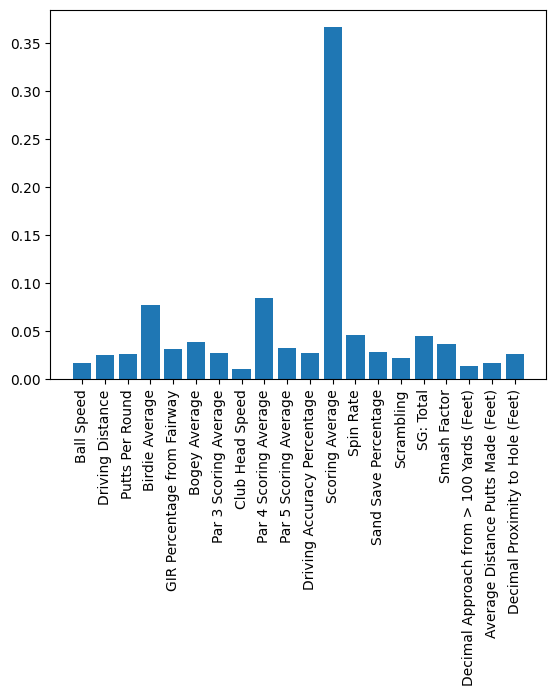

In [17]:
importances = np.mean([tree.feature_importances_ for tree in best_bc.estimators_], axis=0)
importances_dict = {}
for feature, importance in zip(X.columns, importances):
    importances_dict[feature] = importance

#Plot feature importances in the best model
fig, ax = plt.subplots()
ax.bar(x=importances_dict.keys(), height=importances_dict.values())
ax.set_xticklabels(labels=importances_dict.keys(), rotation=90)

From the bar plot above, we can see that the features that are most prevalent in the decsion making process is scoring average, birdie average, and par 4 scoring average. All of these statistics intuitively make sense with regards to our classifications, as a lower scoring average both overall and on par 4's, typically the most difficult kind of hole, will get you better finishes.

## Next Steps
The main next steps that I would suggest is collecting more data specific to the different aspects of the golf game. While the model that was built was good at predicting whether or not a player would have a top ten finish, the features that drove this model the most were not the most insightful as to how the average golfer can improve their game. Therefore, collecting more data that does not directly correlate with scoring will help generate a more useful model